# Predictions of procurement data using LinearSVC
LinearSVC model trained on description of notices from dataset available at s3://d-ew1-ted-ai-experiments-data/CPVs/202302/20230214-dataset-eu-contract-notices.csv.
## Load dataset
Dataset available at s3://d-ew1-ted-ai-experiments-data/CPVs/202302/20230214-dataset-eu-contract-notices.csv
. Here we consider the already preprocessed dataset (see 20230214-data_exploration_and_training.ipynb).

In [3]:
import re
from unidecode import unidecode
import spacy.cli


spacy.cli.download("en_core_web_sm")
NLP = spacy.load("en_core_web_sm")
STOP_WORDS = NLP.Defaults.stop_words
CHARACTERS_TO_REPLACE = ["\\n", "\\r", "\\t", "\\W", "•", "\t", "-", "(", ")", ":", ";", "?", "!", "&", "\n", "\r", ".", ",", "'", "’", "´",
                         "‘", "’", '"', "“", "”", "'", "/", "\\", "%", "—", "#", "$", "[", "]", "|", "{", "}", "~", "`", "+", "*"]

MONTHS = [" january ", " february ", " march ", " april ", " may ", " june ", " july ", " august ", " september ", " october ", " november ", " december ",
          " jan ", " feb ", " mar ", " apr ", " jun ", " jul ", " aug ", " sep ", " oct ", " nov ", " dec "]

          
def _remove_multiple_spaces(text: str) -> str:
    return re.sub('\s+', ' ', text)


def _remove_special_characters(text: str) -> str:
    for chars in CHARACTERS_TO_REPLACE:
        text = text.replace(chars, " ")
    return text


def _remove_stop_words(text: str) -> str:
    doc = NLP(text)
    token_list = [token.text.lower().strip() for token in doc]
    removed_list = [x for x in token_list if x not in STOP_WORDS]
    return ' '.join(removed_list)


def _replace_digits(text):
    return re.sub(r'[\d-]+', 'NUMBER', text)


def _delete_one_letter_word(text):
    text_as_list = text.split()
    text_as_list = [element for element in text_as_list if len(element) > 1]
    return ' '.join(text_as_list)


def _remove_consecutive_duplicates(text):
    text_as_list = text.split()
    last_seen = None
    result = []
    for x in text_as_list:
        if x != last_seen:
            result.append(x)
        last_seen = x
    return ' '.join(result)

          
def _replace_months(text: str) -> str:
    text = " " + text + " "
    for month in MONTHS:
        text = text.replace(month, " MONTH ")
    return text


def _replace_with_lemma(text: str) -> str:
    doc = NLP(text)
    lemmatized_list = []
    for token in doc:
        lemmatized_list.append(token.lemma_)
    return " ".join(lemmatized_list)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Training

In [4]:
from json import JSONEncoder
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC


# adapted from: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(ytest,y_pred):
    y_true = ytest
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    coverage_err = coverage_error(y_true, y_pred)
    label_ranking_average_precision = label_ranking_average_precision_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'coverage_error': coverage_err,
               'label_ranking_average_precision_score': label_ranking_average_precision}
    print(metrics)


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [5]:
from ast import literal_eval
import pandas as pd

df = pd.read_csv("20230214-dataset_preprocessed_with_lemma.csv", index_col=0)

In [6]:
df.head()

title_texte     85     44     50  \
1   ipa supply equipment increase competitiveness...  False   True  False   
3   provision language training service tender in...  False  False  False   
4   service support eda helicopter portfolio main...  False  False  False   
5   NUMBER cp op NUMBER pooling share cost non co...  False  False  False   
6   edf supply transport household similar waste ...  False  False  False   

      80     73     45     71     79     90  ...     18     03     24     43  \
1  False  False  False  False  False  False  ...  False  False  False  False   
3   True  False  False  False  False  False  ...  False  False  False  False   
4   True  False  False  False  False  False  ...  False  False  False  False   
5  False   True  False  False  False  False  ...  False  False  False  False   
6  False  False   True  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
1  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  
5  False  False  False  False  False  False  
6  False  False  False  False  False  False  

[5 rows x 46 columns]

In [7]:
all_cpvs = df.columns.to_list()
all_cpvs.remove("title_texte")
print(all_cpvs)

['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']


In [8]:
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)



SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline.predict(X_test)

clf fit done


In [13]:
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          85       0.82      0.47      0.60        66
          44       0.55      0.19      0.28        32
          50       0.73      0.60      0.66        77
          80       0.78      0.55      0.64       110
          73       0.72      0.73      0.73       258
          45       0.75      0.79      0.77       175
          71       0.67      0.59      0.63       409
          79       0.77      0.75      0.76       692
          90       0.87      0.74      0.80       168
          30       0.73      0.55      0.63        67
          35       0.71      0.29      0.41        42
          33       0.92      0.44      0.60        27
          55       0.84      0.70      0.76        30
          72       0.75      0.62      0.68       213
          48       0.61      0.31      0.41        36
          38       0.71      0.53      0.60        74
          09       0.87      0.59      0.70        34
          75       0.36    

# Extract wrongly assign sentences from procurement data
Dataset available at s3://d-ew1-ted-ai-experiments-data/CPVs/202303/20230301-procurement_data_for_eu_notices.csv

In [9]:
from ast import literal_eval
import pandas as pd
import re
import numpy as np

df = pd.read_csv('procurements_data/20230301-procurement_data_for_eu_notices.csv', dtype={'main_cpv': str}, converters={"additional_cpvs": literal_eval, "procurement_data": literal_eval})
df.tail()

id      notice_type  main_cpv additional_cpvs  \
3818  2020/S 106-255487  Contract notice  34113200              []   
3819  2022/S 125-351443  Contract notice  48461000              []   
3820  2022/S 101-278437  Contract notice  63500000              []   
3821  2018/S 052-114411  Contract notice  79300000              []   
3822  2019/S 118-288646  Contract notice  31682210              []   

                                         etendering_url  \
3818  https://etendering.ted.europa.eu/cft/cft-displ...   
3819  https://etendering.ted.europa.eu/cft/cft-displ...   
3820  https://etendering.ted.europa.eu/cft/cft-displ...   
3821  https://etendering.ted.europa.eu/cft/cft-displ...   
3822  https://etendering.ted.europa.eu/cft/cft-displ...   

                                       procurement_data  
3818  [1 TENDERING SPECIFICATIONS Call for tenders E...  
3819  [ORDER NOEUROPEAN COMMISSION JOINT RESEARCH CE...  
3820  [22ETF02 Tender specifications Regional SEET P...  
3821  [MODEL TERMS OF REFERENCE TENDER SPECIFICATION...  
3822  [index.php NE.45.2301.A.022 ND.45.1001011.A.01...

In [10]:
df['main_cpv'] = df['main_cpv'].apply(lambda x: x[:2])
# Merge additional_cpvs and main_cpv into all_cpvs
all_cpvs = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']

df["all_cpvs"] = ""

for ind, row in df.iterrows():
  main_cpv = row['main_cpv']
  additionnal_cpvs = row['additional_cpvs']
  cpvs_rows = []
  if main_cpv:
    cpvs_rows.append(main_cpv)
  if additionnal_cpvs:
    cpvs_rows.extend(row['additional_cpvs'])

  cpv_to_add = []

  for cpv in cpvs_rows:
    if cpv:
      division_cpv = cpv[:2]
      if division_cpv not in cpv_to_add:
        cpv_to_add.append(division_cpv)
      #if division_cpv not in all_cpvs:
      #  all_cpvs.append(division_cpv)
  row["all_cpvs"] = cpv_to_add

df.head(5)

id      notice_type main_cpv additional_cpvs  \
0  2017/S 102-203726  Contract notice       85              []   
1  2014/S 138-246767  Contract notice       80              []   
2  2017/S 164-337354  Contract notice       80              []   
3  2016/S 070-121405  Contract notice       73              []   
4  2022/S 084-222910  Contract notice       71              []   

                                      etendering_url  \
0  https://etendering.ted.europa.eu/cft/cft-displ...   
1  https://etendering.ted.europa.eu/cft/cft-displ...   
2  https://etendering.ted.europa.eu/cft/cft-displ...   
3  https://etendering.ted.europa.eu/cft/cft-displ...   
4  https://etendering.ted.europa.eu/cft/cft-displ...   

                                    procurement_data all_cpvs  
0  [Tender Specificationsopen callreview july 201...     [85]  
1  [Annex12013POEJ4.DOCX ANNEX 1 2014/PO/EJ/10 Pa...     [80]  
2  [4102cahierdeschargesopenprocedureenjuly2010.d...     [80]  
3  [4102cahierdeschargesopenprocedureenjuly2010.d...     [73]  
4  [European Commission DG Joint Research Centre ...     [71]

In [11]:
df.describe()

id      notice_type main_cpv additional_cpvs  \
count                3823             3823     3823            3823   
unique               3823                4       42              63   
top     2017/S 102-203726  Contract notice       79              []   
freq                    1             3740     1095            3755   

                                           etendering_url  \
count                                                3823   
unique                                               3744   
top     https://etendering.ted.europa.eu/cft/cft-displ...   
freq                                                    2   

                                         procurement_data all_cpvs  
count                                                3823     3823  
unique                                               3741       76  
top     [Model specifications EN 2. The Tender and the...     [79]  
freq                                                    2     1088

In [12]:
all_results = []
count_by_division = {}
#max_sentences_by_division = 400
max_doc = 823
extract_sentences = []
for index, row in df.iterrows():
    if index > max_doc:
        break
    procurement_data = row["procurement_data"]
    expected_cpvs = row["all_cpvs"]
    
    merged_procurement_data = " ".join(procurement_data)
    merged_procurement_data = re.sub('http://\S+|https://\S+', '', merged_procurement_data)
    splitted_by_dot = list(filter(None, merged_procurement_data.split(".")))
    result_row = []
    for element in splitted_by_dot:

        if len(element) < 100 or len(element) > 510:
            continue
        
        text_input = unidecode(element.lower())
        text_input = _remove_special_characters(text_input)
        text_input = _replace_with_lemma(text_input)
        text_input = _remove_stop_words(text_input)
        text_input = _remove_multiple_spaces(text_input)
        text_input = _replace_digits(text_input)
        text_input = _delete_one_letter_word(text_input)
        text_input = _remove_consecutive_duplicates(text_input)
        text_input = _replace_months(text_input)
        result = SVC_pipeline.predict([text_input])
        results_as_division = [all_cpvs[ind] for ind, element in enumerate(result[0]) if element]
        if results_as_division:
            for lab in results_as_division:
                result_row.append(lab)
                if lab not in expected_cpvs:
                    current_count = count_by_division.get(lab, 0)
                    #if current_count < max_sentences_by_division:
                    count_by_division[lab] = current_count + 1
                    local_result = [lab, text_input]
                    extract_sentences.append(local_result)


    all_results.append(set(result_row))

In [13]:
print(count_by_division)

{'79': 25806, '45': 1734, '73': 4489, '33': 33, '72': 3525, '50': 361, '71': 1788, '63': 392, '30': 462, '90': 1772, '64': 111, '38': 115, '31': 97, '80': 1596, '48': 393, '66': 496, '85': 145, '55': 166, '98': 13, '24': 8, '34': 231, '15': 14, '09': 49, '77': 4, '35': 54, '42': 44, '39': 135, '60': 56, '92': 67, '32': 106, '14': 3, '44': 2, '75': 12, '18': 9, '22': 20, '51': 1, '03': 5, '70': 3, '65': 1}


In [14]:
df_noise = pd.DataFrame(extract_sentences, columns =['predicted', 'text'])
df_noise.head()

predicted                                               text
0        79   NUMBER participation tender procedure procure...
1        79   NUMBER tender specification legal capacity al...
2        79   note attempt tenderer obtain confidential inf...
3        45   NUMBER subcontract envisage tenderer clearly ...
4        45   subcontractor work assume carry directly tend...

In [15]:
df_noise.describe()

predicted                                               text
count      44318                                              44318
unique        39                                              27361
top           79   document describe issue country concern repla...
freq       25806                                                143

In [16]:
df_noise = df_noise.drop_duplicates(subset=['text'], keep='last')
df_noise.describe()

predicted                                               text
count      27361                                              27361
unique        39                                              27361
top           79   monitor impact seasonal influenza vaccination...
freq       14363                                                  1

In [17]:
df_noise.to_csv("noise_from_procurement_data_lemmatized_823doc_no_limit.csv")

In [18]:
df_noise = pd.read_csv("noise_from_procurement_data_lemmatized_823doc_no_limit.csv", index_col=0)
df_noise.head(1)

predicted                                               text
9         73   monitor impact seasonal influenza vaccination...

In [19]:
df.head(1)

id      notice_type main_cpv additional_cpvs  \
0  2017/S 102-203726  Contract notice       85              []   

                                      etendering_url  \
0  https://etendering.ted.europa.eu/cft/cft-displ...   

                                    procurement_data all_cpvs  
0  [Tender Specificationsopen callreview july 201...     [85]

In [20]:
df_unchanged = pd.read_csv("20230214-dataset_preprocessed_with_lemma.csv", index_col=0)
all_cpvs = df_unchanged.columns.to_list()
all_cpvs.remove("title_texte")
print(all_cpvs)

['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']


In [21]:
df_unchanged.head(1)

title_texte     85    44     50  \
1   ipa supply equipment increase competitiveness...  False  True  False   

      80     73     45     71     79     90  ...     18     03     24     43  \
1  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
1  False  False  False  False  False  False  

[1 rows x 46 columns]

In [22]:
formatted_noise = []
columns_unchanged = df_unchanged.columns.to_list()
number_column_to_fill = len(columns_unchanged) - 1
column_to_fill_with_false = [False for _ in range(number_column_to_fill)]

for index, row in df_noise.iterrows():
    local_result = [row["text"]]
    local_result.extend(column_to_fill_with_false)
    formatted_noise.append(local_result)


In [23]:
df_noise_formatted = pd.DataFrame(formatted_noise, columns =columns_unchanged)
df_noise_formatted.head(1)

title_texte     85     44     50  \
0   monitor impact seasonal influenza vaccination...  False  False  False   

      80     73     45     71     79     90  ...     18     03     24     43  \
0  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  

[1 rows x 46 columns]

In [24]:
df_merged = pd.concat([df_unchanged, df_noise_formatted])
df_merged.head(1)

title_texte     85    44     50  \
1   ipa supply equipment increase competitiveness...  False  True  False   

      80     73     45     71     79     90  ...     18     03     24     43  \
1  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
1  False  False  False  False  False  False  

[1 rows x 46 columns]

In [25]:
all_cpvs = df_merged.columns.to_list()
all_cpvs.remove("title_texte")
print(all_cpvs)

['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']


In [26]:
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


X = df_merged['title_texte']
Y = df_merged.drop(['title_texte'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)



SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

clf fit done


/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

              precision    recall  f1-score   support

          85       0.83      0.57      0.67        67
          44       0.71      0.21      0.32        24
          50       0.78      0.50      0.61        70
          80       0.86      0.59      0.70       123
          73       0.64      0.55      0.59       264
          45       0.78      0.70      0.74       177
          71       0.66      0.60      0.63       436
          79       0.68      0.67      0.67       679
          90       0.79      0.62      0.69       163
          30       0.71      0.47      0.57        68
          35       0.44      0.21      0.29        33
          33       0.76      0.40      0.52        40
          55       0.82      0.60      0.69        30
          72       0.69      0.49      0.57       228
          48       0.38      0.06      0.11        48
          38       0.65      0.48      0.55        69
          09       0.67      0.50      0.57        28
          75       0.48    

In [27]:
df_merged.describe()

title_texte     85     44  \
count                                               41920  41920  41920   
unique                                              41920      2      2   
top      ipa supply equipment increase competitiveness...  False  False   
freq                                                    1  41602  41794   

           50     80     73     45     71     79     90  ...     18     03  \
count   41920  41920  41920  41920  41920  41920  41920  ...  41920  41920   
unique      2      2      2      2      2      2      2  ...      2      2   
top     False  False  False  False  False  False  False  ...  False  False   
freq    41555  41418  40604  40998  39895  38550  41115  ...  41880  41884   

           24     43     19     41     37     14     16     76  
count   41920  41920  41920  41920  41920  41920  41920  41920  
unique      2      2      2      2      2      2      2      2  
top     False  False  False  False  False  False  False  False  
freq    41879  41902  41908  41905  41904  41898  41911  41912  

[4 rows x 46 columns]

Now try on procurement data unseen

In [28]:
all_results = []
count_by_division = {}
max_doc = 823
extract_sentences = []
for index, row in df.iterrows():
    if index <= max_doc:
        continue
    procurement_data = row["procurement_data"]
    expected_cpvs = row["all_cpvs"]
    
    merged_procurement_data = " ".join(procurement_data)
    merged_procurement_data = re.sub('http://\S+|https://\S+', '', merged_procurement_data)
    splitted_by_dot = list(filter(None, merged_procurement_data.split(".")))
    result_row = []
    for element in splitted_by_dot:

        if len(element) < 100 or len(element) > 510:
            continue
        
        text_input = unidecode(element.lower())
        text_input = _remove_special_characters(text_input)
        text_input = _replace_with_lemma(text_input)
        text_input = _remove_stop_words(text_input)
        text_input = _remove_multiple_spaces(text_input)
        text_input = _replace_digits(text_input)
        text_input = _delete_one_letter_word(text_input)
        text_input = _remove_consecutive_duplicates(text_input)
        text_input = _replace_months(text_input)
        result = SVC_pipeline.predict([text_input])
        results_as_division = [all_cpvs[ind] for ind, element in enumerate(result[0]) if element]
        if results_as_division:
            for lab in results_as_division:
                result_row.append(lab)

    all_results.append(set(result_row))

In [29]:
print(all_results)

[set(), {'80'}, {'38'}, {'79'}, {'72', '79'}, {'55'}, {'35'}, {'90', '30', '50', '72', '71', '32', '79', '42', '45', '31', '66'}, set(), {'38'}, set(), {'80', '63', '90'}, {'79'}, {'50', '72'}, {'77', '64', '79'}, set(), {'79'}, {'73', '66'}, {'90'}, {'73'}, {'79', '85'}, {'79', '73'}, {'79'}, {'38'}, {'79'}, {'72', '71', '73'}, {'32', '64', '79', '31'}, {'79'}, {'90', '79'}, {'34', '71', '32', '09', '24', '45'}, {'79'}, {'73'}, {'72'}, {'72', '64', '90', '79'}, {'55', '79', '66'}, {'09'}, {'50'}, {'90', '30', '50', '72', '79', '80', '64'}, {'48', '90', '79', '60'}, {'09'}, {'60'}, {'90', '79', '73'}, {'79'}, {'71', '45', '79', '73'}, {'72', '79', '73'}, {'80'}, {'79'}, {'79', '73'}, {'34', '50', '30'}, {'79'}, {'80', '33'}, {'72', '79'}, {'85'}, {'79'}, {'85'}, {'79'}, {'71'}, {'90'}, {'79', '73'}, {'79', '73'}, {'90'}, {'33'}, {'79', '85'}, {'72', '79'}, {'80', '72', '48', '79'}, {'79'}, {'72'}, {'32', '72', '48', '79'}, {'80', '55', '71'}, {'90', '35', '79', '85', '80'}, {'90'}, {'6

In [30]:
import copy
df_copied = copy.deepcopy(df[max_doc+1:])

In [31]:
df_copied["predicted"] = all_results
df_copied.head()

id      notice_type main_cpv additional_cpvs  \
824  2015/S 064-111775  Contract notice       72      [72500000]   
825  2019/S 217-531567  Contract notice       80              []   
826  2021/S 171-443405  Contract notice       38              []   
827  2022/S 247-713802  Contract notice       79              []   
828  2017/S 160-329621  Contract notice       72              []   

                                        etendering_url  \
824  https://etendering.ted.europa.eu/cft/cft-displ...   
825  https://etendering.ted.europa.eu/cft/cft-displ...   
826  https://etendering.ted.europa.eu/cft/cft-displ...   
827  https://etendering.ted.europa.eu/cft/cft-displ...   
828  https://etendering.ted.europa.eu/cft/cft-displ...   

                                      procurement_data all_cpvs predicted  
824  [Commission europenne B1049 Bruxelles / Europe...     [72]        {}  
825  [Consumers Health Agriculture and Food Executi...     [80]      {80}  
826  [EUROPEAN COMMISSION JOINT RESEARCH CENTRE Dir...     [38]      {38}  
827  [Annex III Technical annex for the services 1....     [79]      {79}  
828  [Model specifications EN Annex 13 CV Descripti...     [72]  {72, 79}

In [32]:
df_copied = df_copied.drop(['notice_type', 'etendering_url', 'procurement_data'], axis = 1)
df_copied.to_csv("with_noise_800docs_linearsvc_model_procurement_data_actual_vs_predicted.csv")

In [33]:
import pandas as pd
from ast import literal_eval

df_copied = pd.read_csv("with_noise_800docs_linearsvc_model_procurement_data_actual_vs_predicted.csv", dtype={'main_cpv': str}, converters={"additional_cpvs": literal_eval}, index_col=0)

In [34]:
for index, row in df_copied.iterrows():
    row_value = row["predicted"]
    row_value = row_value.replace("{", "")
    row_value = row_value.replace("}", "")
    row_value = row_value.replace("'", "")
    row_value = row_value.replace("set()", "")
    row_value = row_value.split(",")
    new_result = [x.strip() for x in row_value]
    row["predicted"] = new_result



In [35]:
df_copied.head()

id main_cpv additional_cpvs all_cpvs predicted
824  2015/S 064-111775       72      [72500000]   ['72']        []
825  2019/S 217-531567       80              []   ['80']      [80]
826  2021/S 171-443405       38              []   ['38']      [38]
827  2022/S 247-713802       79              []   ['79']      [79]
828  2017/S 160-329621       72              []   ['72']  [72, 79]

In [36]:
df_copied['main_cpv'] = df_copied['main_cpv'].apply(lambda x: x[:2])
# Merge additional_cpvs and main_cpv into all_cpvs
all_cpvs = []
df_copied["all_cpvs"] = ""

for ind, row in df_copied.iterrows():
  main_cpv = row['main_cpv']
  additionnal_cpvs = row['additional_cpvs']
  cpvs_rows = []
  if main_cpv:
    cpvs_rows.append(main_cpv)
  if additionnal_cpvs:
    cpvs_rows.extend(row['additional_cpvs'])

  cpv_to_add = []

  for cpv in cpvs_rows:
    if cpv:
      division_cpv = cpv[:2]
      if division_cpv not in cpv_to_add:
        cpv_to_add.append(division_cpv)
      if division_cpv not in all_cpvs:
        all_cpvs.append(division_cpv)
  row["all_cpvs"] = cpv_to_add

df_copied.head(5)

id main_cpv additional_cpvs all_cpvs predicted
824  2015/S 064-111775       72      [72500000]     [72]        []
825  2019/S 217-531567       80              []     [80]      [80]
826  2021/S 171-443405       38              []     [38]      [38]
827  2022/S 247-713802       79              []     [79]      [79]
828  2017/S 160-329621       72              []     [72]  [72, 79]

In [37]:
proportion_division_in_prediction = []
for ind, row in df_copied.iterrows():
    local_result = 0
    number_cpvs = len(row["all_cpvs"])
    for individual_cpv in row["all_cpvs"]:
        if individual_cpv in row["predicted"]:
            local_result += 1
    
    proportion_division_in_prediction.append(local_result/number_cpvs)

df_copied["prop_div_in_pred"] = proportion_division_in_prediction
df_copied.head()

id main_cpv additional_cpvs all_cpvs predicted  \
824  2015/S 064-111775       72      [72500000]     [72]        []   
825  2019/S 217-531567       80              []     [80]      [80]   
826  2021/S 171-443405       38              []     [38]      [38]   
827  2022/S 247-713802       79              []     [79]      [79]   
828  2017/S 160-329621       72              []     [72]  [72, 79]   

     prop_div_in_pred  
824               0.0  
825               1.0  
826               1.0  
827               1.0  
828               1.0

{0.0: 436, 0.16666666666666666: 1, 0.3333333333333333: 1, 0.5: 6, 0.6: 1, 0.6666666666666666: 2, 1.0: 2552}


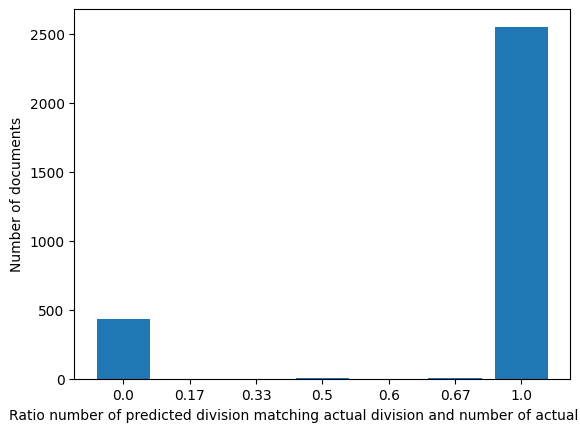

In [38]:
import matplotlib
import matplotlib.pyplot as plt

value_count = dict(df_copied['prop_div_in_pred'].value_counts())
ordered_keys_value_count = dict(sorted(value_count.items()))
print(ordered_keys_value_count)
font = {'size': 10}
matplotlib.rc('font', **font)

x_axis = list(ordered_keys_value_count.keys())
x_axis = [round(x, 2) for x in x_axis]
plt.bar(range(len(ordered_keys_value_count)), ordered_keys_value_count.values(), tick_label=x_axis)
plt.ylabel("Number of documents")
plt.xlabel("Ratio number of predicted division matching actual division and number of actual division")
plt.show()


In [39]:
number_of_wrong_division = []
for ind, row in df_copied.iterrows():
    local_result = 0
    for individual_cpv in row["predicted"]:
        if individual_cpv not in row["all_cpvs"]:
            local_result += 1
    
    number_of_wrong_division.append(local_result)
    
df_copied["number_wrong_predicted_division"] = number_of_wrong_division
df_copied.head()


id main_cpv additional_cpvs all_cpvs predicted  \
824  2015/S 064-111775       72      [72500000]     [72]        []   
825  2019/S 217-531567       80              []     [80]      [80]   
826  2021/S 171-443405       38              []     [38]      [38]   
827  2022/S 247-713802       79              []     [79]      [79]   
828  2017/S 160-329621       72              []     [72]  [72, 79]   

     prop_div_in_pred  number_wrong_predicted_division  
824               0.0                                1  
825               1.0                                0  
826               1.0                                0  
827               1.0                                0  
828               1.0                                1

{0: 1304, 1: 1067, 2: 363, 3: 143, 4: 67, 5: 28, 6: 15, 7: 5, 9: 2, 10: 3, 11: 1, 14: 1}


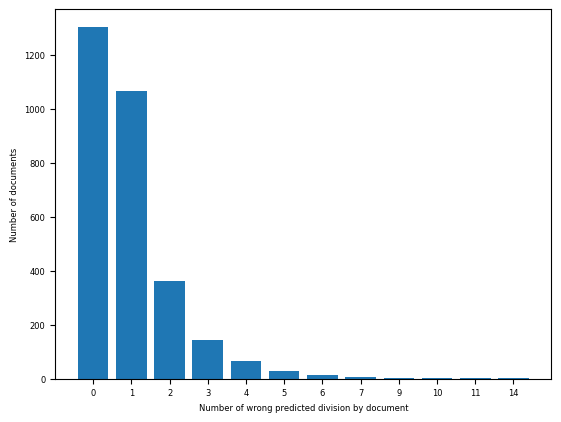

In [40]:
value_count = dict(df_copied['number_wrong_predicted_division'].value_counts())
ordered_keys_value_count = dict(sorted(value_count.items()))
print(ordered_keys_value_count)
font = {'size': 6}
matplotlib.rc('font', **font)

x_axis = list(ordered_keys_value_count.keys())
x_axis = [round(x, 2) for x in x_axis]
plt.bar(range(len(ordered_keys_value_count)), ordered_keys_value_count.values(), tick_label=x_axis)
plt.ylabel("Number of documents")
plt.xlabel("Number of wrong predicted division by document")
plt.show()

In [41]:
wrong_divisions = []
for ind, row in df_copied.iterrows():
    local_result = []
    for individual_cpv in row["predicted"]:
        if individual_cpv not in row["all_cpvs"]:
            local_result.append(individual_cpv)
    
    wrong_divisions.append(local_result)
    
df_copied["wrong_divisions"] = wrong_divisions
df_copied.head()


id main_cpv additional_cpvs all_cpvs predicted  \
824  2015/S 064-111775       72      [72500000]     [72]        []   
825  2019/S 217-531567       80              []     [80]      [80]   
826  2021/S 171-443405       38              []     [38]      [38]   
827  2022/S 247-713802       79              []     [79]      [79]   
828  2017/S 160-329621       72              []     [72]  [72, 79]   

     prop_div_in_pred  number_wrong_predicted_division wrong_divisions  
824               0.0                                1              []  
825               1.0                                0              []  
826               1.0                                0              []  
827               1.0                                0              []  
828               1.0                                1            [79]

In [42]:
import matplotlib
import matplotlib.pyplot as plt

font = {'size': 22}
matplotlib.rc('font', **font)


def create_barplot_from_dict(dictionary, threshold):
    plt.figure(figsize=(24,10))
    plt.bar(dictionary.keys(), dictionary.values(), color='b', edgecolor='k', alpha=0.65)
    if threshold:
        plt.axhline(y=threshold,linewidth=2, color='r')
    plt.xticks(rotation=90)



def count_elements_in_dataframe_from_columns(df, list_column_names):
    found_aggregation = dict()
    for _, row in df.iterrows():
        for column_name in list_column_names:
            if row[column_name]:
                if column_name not in found_aggregation:
                    found_aggregation[column_name] = 1
                else:
                    found_aggregation[column_name] = found_aggregation[column_name] + 1

    return found_aggregation

In [43]:
number_wrong_division_prediction = {}
for ind, row in df_copied.iterrows():
    for individual_cpv in row["wrong_divisions"]:
        if individual_cpv not in number_wrong_division_prediction.keys():
            number_wrong_division_prediction[individual_cpv] = 1
        else:
            number_wrong_division_prediction[individual_cpv] += 1

print(number_wrong_division_prediction)

{'': 180, '79': 595, '90': 191, '30': 65, '72': 145, '71': 241, '32': 45, '42': 34, '45': 155, '31': 18, '66': 83, '80': 95, '63': 17, '50': 77, '64': 42, '73': 311, '34': 58, '09': 31, '24': 21, '55': 33, '60': 36, '33': 25, '48': 26, '35': 38, '85': 64, '39': 42, '38': 72, '18': 7, '14': 1, '77': 14, '22': 5, '15': 7, '92': 19, '44': 9, '98': 11, '70': 2, '75': 11, '03': 1, '43': 1}


Text(0.5, 0, 'CPV division')

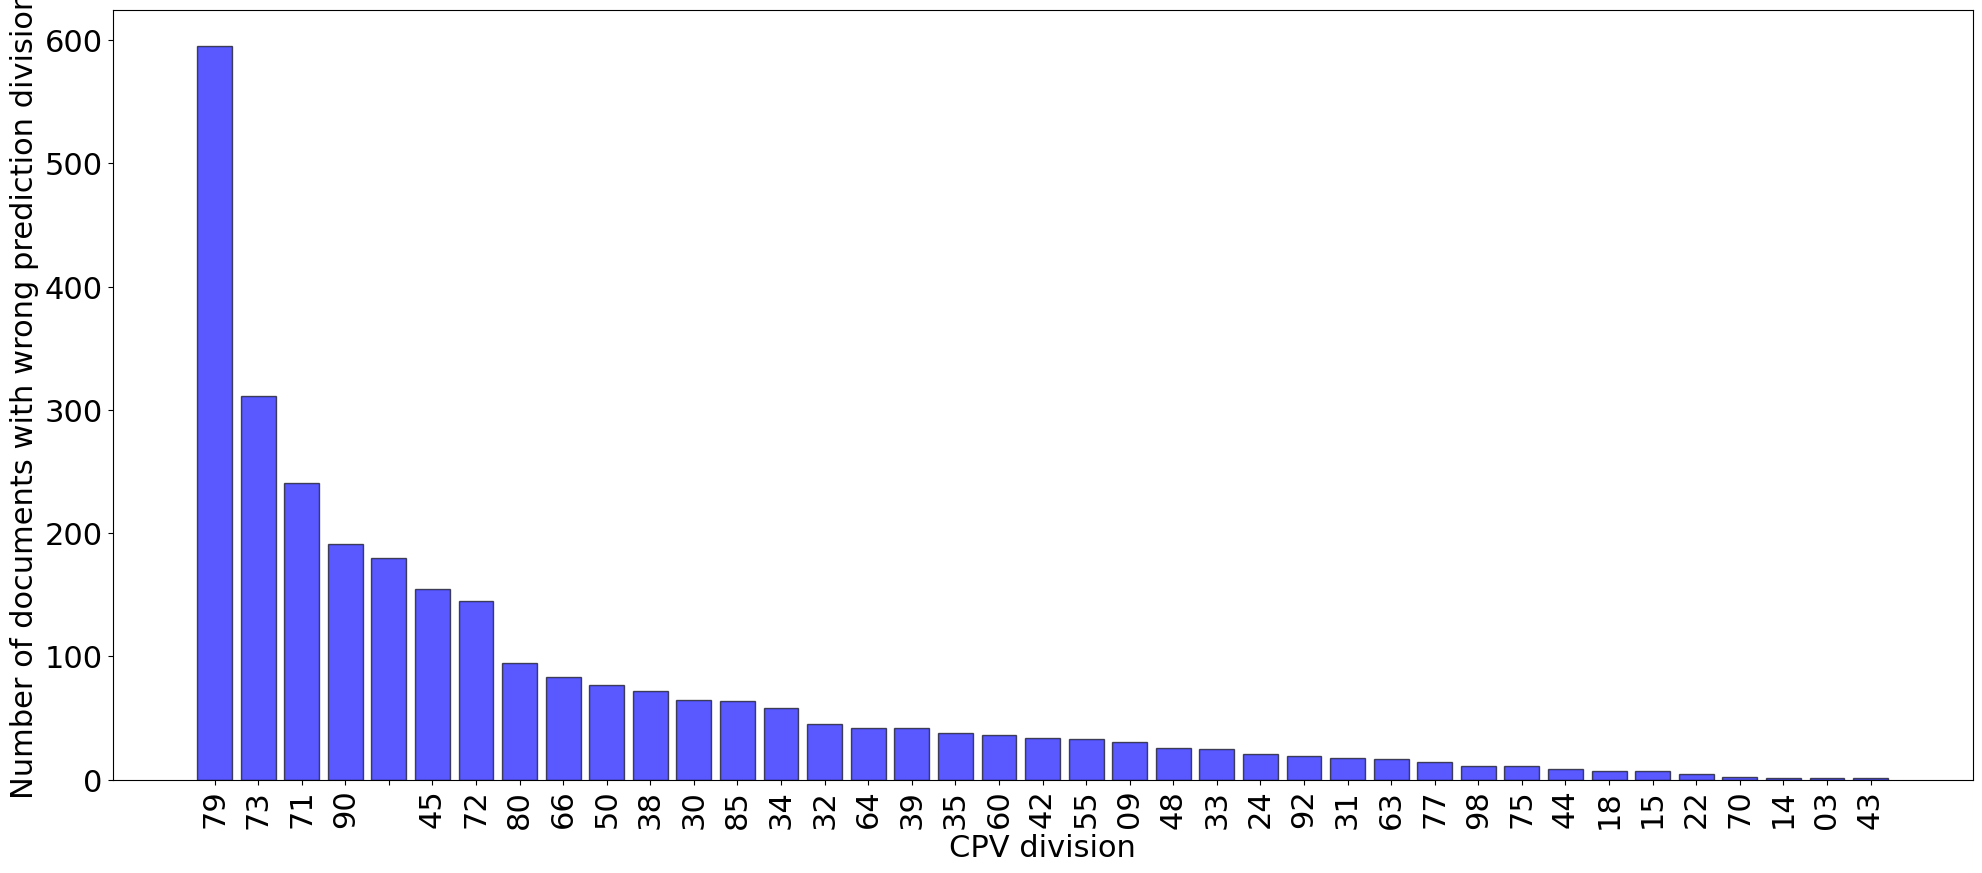

In [44]:
sorted_count_of_cpvs = dict(sorted(number_wrong_division_prediction.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents with wrong prediction division")
plt.xlabel("CPV division")

In [45]:
sorted_count_of_cpvs

{'79': 595,
 '73': 311,
 '71': 241,
 '90': 191,
 '': 180,
 '45': 155,
 '72': 145,
 '80': 95,
 '66': 83,
 '50': 77,
 '38': 72,
 '30': 65,
 '85': 64,
 '34': 58,
 '32': 45,
 '64': 42,
 '39': 42,
 '35': 38,
 '60': 36,
 '42': 34,
 '55': 33,
 '09': 31,
 '48': 26,
 '33': 25,
 '24': 21,
 '92': 19,
 '31': 18,
 '63': 17,
 '77': 14,
 '98': 11,
 '75': 11,
 '44': 9,
 '18': 7,
 '15': 7,
 '22': 5,
 '70': 2,
 '14': 1,
 '03': 1,
 '43': 1}

In [46]:
total_wrong = 0
for key, value in sorted_count_of_cpvs.items():
    total_wrong += value

print(f"Total wrong predictions: {total_wrong}")

Total wrong predictions: 2828


Here follows results of wrong predictions per division for different models that we previously trained

In [47]:
roberta_results = {'71': 3537,
 '72': 2911,
 '66': 2883,
 '75': 2773,
 '79': 2652,
 '73': 2426,
 '80': 2208,
 '90': 2048,
 '63': 1493,
 '48': 1319,
 '30': 1181,
 '45': 1074,
 '60': 739,
 '55': 656,
 '32': 642,
 '64': 541,
 '34': 525,
 '50': 518,
 '39': 424,
 '85': 390,
 '35': 374,
 '38': 298,
 '92': 252,
 '33': 250,
 '42': 222,
 '31': 188,
 '22': 170,
 '77': 151,
 '09': 150,
 '70': 82,
 '44': 55,
 '15': 24,
 '18': 24,
 '': 13,
 '98': 9}

linera_svc_results = {'79': 2622,
 '73': 2544,
 '71': 2349,
 '45': 2344,
 '72': 2137,
 '90': 2049,
 '80': 1593,
 '66': 1361,
 '63': 950,
 '30': 689,
 '48': 682,
 '50': 440,
 '64': 425,
 '32': 339,
 '55': 319,
 '34': 295,
 '85': 291,
 '38': 253,
 '39': 194,
 '60': 126,
 '35': 119,
 '31': 118,
 '09': 111,
 '92': 109,
 '42': 104,
 '33': 74,
 '22': 62,
 '75': 39,
 '15': 37,
 '18': 34,
 '98': 31,
 '44': 27,
 '77': 26,
 '14': 25,
 '24': 24,
 '03': 21,
 '': 21,
 '70': 10,
 '65': 3,
 '43': 2,
 '41': 1,
 '51': 1,
 '76': 1}
linera_svc_with_proc_results_100 = {'79': 2462,
 '73': 1897,
 '72': 1432,
 '45': 1044,
 '71': 1037,
 '90': 945,
 '80': 817,
 '30': 689,
 '66': 533,
 '48': 393,
 '50': 330,
 '32': 250,
 '34': 240,
 '63': 217,
 '85': 186,
 '39': 181,
 '55': 168,
 '38': 161,
 '64': 147,
 '92': 126,
 '31': 118,
 '35': 116,
 '60': 110,
 '09': 79,
 '33': 74,
 '42': 72,
 '22': 61,
 '77': 33,
 '18': 32,
 '24': 29,
 '': 28,
 '15': 26,
 '98': 24,
 '75': 23,
 '03': 22,
 '44': 19,
 '70': 14,
 '14': 4,
 '65': 2,
 '43': 2,
 '41': 1,
 '51': 1,
 '76': 1}
linera_svc_with_proc_results_300 = {'79': 2020,
 '73': 1243,
 '72': 912,
 '71': 849,
 '90': 769,
 '45': 442,
 '80': 373,
 '66': 305,
 '30': 218,
 '48': 194,
 '34': 191,
 '50': 185,
 '32': 177,
 '85': 169,
 '38': 132,
 '39': 131,
 '55': 123,
 '64': 99,
 '35': 79,
 '63': 72,
 '60': 71,
 '31': 67,
 '09': 66,
 '33': 64,
 '92': 53,
 '42': 46,
 '': 37,
 '98': 35,
 '18': 30,
 '75': 27,
 '77': 24,
 '22': 19,
 '15': 15,
 '44': 14,
 '24': 11,
 '70': 9,
 '03': 5,
 '14': 2,
 '43': 2,
 '76': 1}
linera_svc_with_proc_results_500 = {'79': 858,
 '73': 502,
 '71': 463,
 '30': 387,
 '90': 291,
 '72': 285,
 '80': 231,
 '45': 219,
 '66': 150,
 '50': 127,
 '': 117,
 '85': 108,
 '32': 95,
 '34': 94,
 '38': 94,
 '39': 76,
 '31': 67,
 '35': 59,
 '48': 56,
 '55': 55,
 '09': 53,
 '64': 50,
 '92': 46,
 '42': 44,
 '63': 43,
 '60': 43,
 '33': 41,
 '77': 26,
 '75': 15,
 '44': 13,
 '24': 13,
 '98': 11,
 '15': 10,
 '18': 9,
 '22': 9,
 '03': 8,
 '70': 7,
 '65': 3,
 '14': 1,
 '43': 1}
linera_svc_with_proc_results_800 = {'79': 595,
 '73': 311,
 '71': 241,
 '90': 191,
 '': 180,
 '45': 155,
 '72': 145,
 '80': 95,
 '66': 83,
 '50': 77,
 '38': 72,
 '30': 65,
 '85': 64,
 '34': 58,
 '32': 45,
 '64': 42,
 '39': 42,
 '35': 38,
 '60': 36,
 '42': 34,
 '55': 33,
 '09': 31,
 '48': 26,
 '33': 25,
 '24': 21,
 '92': 19,
 '31': 18,
 '63': 17,
 '77': 14,
 '98': 11,
 '75': 11,
 '44': 9,
 '18': 7,
 '15': 7,
 '22': 5,
 '70': 2,
 '14': 1,
 '03': 1,
 '43': 1}

In [48]:
all_divisions = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76', '']

In [49]:
ordered_roberta_wrong_divisions = {}
for element in all_divisions:
    if element in list(roberta_results.keys()):
        ordered_roberta_wrong_divisions[element] = roberta_results[element]
    else:
        ordered_roberta_wrong_divisions[element] = 0

In [50]:
ordered_linear_svc_wrong_divisions = {}
number_proc_doc_first_eval = 3823
for element in all_divisions:
    if element in list(linera_svc_results.keys()):
        ordered_linear_svc_wrong_divisions[element] = linera_svc_results[element] / number_proc_doc_first_eval
    else:
        ordered_linear_svc_wrong_divisions[element] = 0

In [51]:
ordered_linear_svc_with_proc_100_wrong_divisions = {}
number_proc_doc_second_eval = 3722

for element in all_divisions:
    if element in list(linera_svc_with_proc_results_100.keys()):
        ordered_linear_svc_with_proc_100_wrong_divisions[element] = linera_svc_with_proc_results_100[element] / number_proc_doc_second_eval
    else:
        ordered_linear_svc_with_proc_100_wrong_divisions[element] = 0

In [52]:
ordered_linear_svc_with_proc_300_wrong_divisions = {}
number_proc_doc_second_eval = 3522

for element in all_divisions:
    if element in list(linera_svc_with_proc_results_300.keys()):
        ordered_linear_svc_with_proc_300_wrong_divisions[element] = linera_svc_with_proc_results_300[element] / number_proc_doc_second_eval
    else:
        ordered_linear_svc_with_proc_300_wrong_divisions[element] = 0

In [53]:
ordered_linear_svc_with_proc_500_wrong_divisions = {}
number_proc_doc_second_eval = 3322

for element in all_divisions:
    if element in list(linera_svc_with_proc_results_500.keys()):
        ordered_linear_svc_with_proc_500_wrong_divisions[element] = linera_svc_with_proc_results_500[element] / number_proc_doc_second_eval
    else:
        ordered_linear_svc_with_proc_500_wrong_divisions[element] = 0

In [54]:
ordered_linear_svc_with_proc_800_wrong_divisions = {}
number_proc_doc_second_eval = 2999

for element in all_divisions:
    if element in list(linera_svc_with_proc_results_800.keys()):
        ordered_linear_svc_with_proc_800_wrong_divisions[element] = linera_svc_with_proc_results_800[element] / number_proc_doc_second_eval
    else:
        ordered_linear_svc_with_proc_800_wrong_divisions[element] = 0

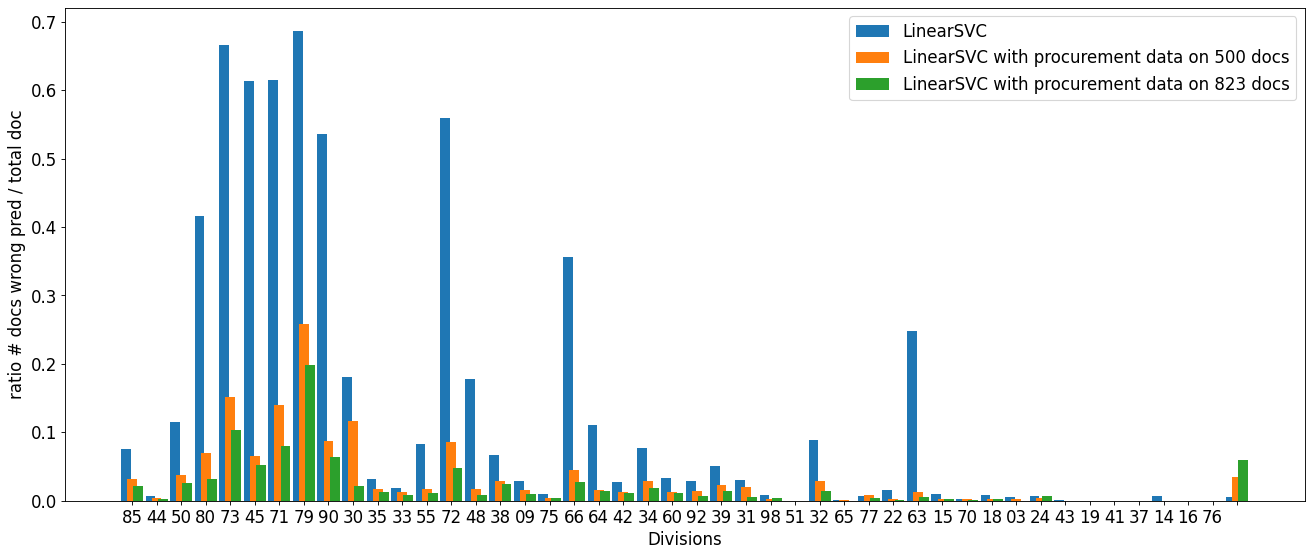

In [56]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

figure(figsize=(20, 8), dpi=80)
font = {'size': 15}
matplotlib.rc('font', **font)

X = list(ordered_linear_svc_wrong_divisions.keys())
#values_roberta = list(ordered_roberta_wrong_divisions.values())
values_linear_svc = list(ordered_linear_svc_wrong_divisions.values())
values_linear_svc_with_proc_100 = list(ordered_linear_svc_with_proc_100_wrong_divisions.values())
values_linear_svc_with_proc_300 = list(ordered_linear_svc_with_proc_300_wrong_divisions.values())
values_linear_svc_with_proc_500 = list(ordered_linear_svc_with_proc_500_wrong_divisions.values())
values_linear_svc_with_proc_800 = list(ordered_linear_svc_with_proc_800_wrong_divisions.values())


  
X_axis = np.arange(len(X))
  
#plt.bar(X_axis - 0.25, values_roberta, 0.4, label = 'Roberta-base')
plt.bar(X_axis - 0.25, values_linear_svc, 0.4, label = 'LinearSVC')
plt.bar(X_axis + 0, values_linear_svc_with_proc_500, 0.4, label = 'LinearSVC with procurement data on 500 docs')
plt.bar(X_axis + 0.25, values_linear_svc_with_proc_800, 0.4, label = 'LinearSVC with procurement data on 823 docs')


  
plt.xticks(X_axis, X)
plt.xlabel("Divisions")
plt.ylabel("ratio # docs wrong pred / total doc")
plt.legend()
plt.show()